# Bitcoin’s Price Time Series Forecasting

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


/Users/taraahmadi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [36]:
BTC = pd.read_csv('/Users/taraahmadi/Desktop/Data Science_ Brain Station/BTC.csv' , index_col = 0)

In [37]:
BTC.index = pd.to_datetime(BTC.index)
BTC.index.names = [None]
BTC.head()

Open    High     Low   Close Volume     Market Cap
2013-04-28  135.30  135.98  132.10  134.21      -  1,500,520,000
2013-04-29  134.44  147.49  134.00  144.54      -  1,491,160,000
2013-04-30  144.00  146.93  134.05  139.00      -  1,597,780,000
2013-05-01  139.00  139.89  107.72  116.99      -  1,542,820,000
2013-05-02  116.38  125.60   92.28  105.21      -  1,292,190,000

In [38]:
BTC.describe()

Open         High          Low        Close
count  1662.000000  1662.000000  1662.000000  1662.000000
mean    847.058375   872.099627   824.153057   850.918706
std    1170.904053  1214.312804  1134.892378  1179.594683
min      68.500000    74.560000    65.530000    68.430000
25%     264.525000   270.695000   260.727500   264.622500
50%     453.965000   458.730000   445.945000   454.525000
75%     751.807500   770.310000   734.582500   751.612500
max    7446.830000  7776.420000  7333.190000  7459.690000

In [39]:
BTC_Close = pd.DataFrame(BTC['Close'])

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

cf.go_offline()

BTC_Close.iplot(kind='scatter', mode='markers',size= 2,xTitle = 'Date' , yTitle = 'Price in USD', filename='cufflinks/simple-scatter')

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations

In [40]:
BTC['Close'].resample('A').agg('mean')      # The mean price is over a year , A is for year end frequency

2013-12-31     257.474476
2014-12-31     527.236658
2015-12-31     272.453260
2016-12-31     568.492131
2017-12-31    2674.271321
Freq: A-DEC, Name: Close, dtype: float64

To get the change in daily close price :

In [41]:
BTC['BTC Daily Return'] = ((BTC['Close'] - BTC['Close'].shift(1)) / BTC['Close'].shift(1))* 100

In [42]:
BTC['BTC Daily Return'].iplot(kind='line', title = 'Bitcoin Daily Percentage change', xTitle = 'Date' , yTitle = 'Daily Percentage change', world_readable=False)

As we can see the daily percentage change is more stationary than the daily price. So I'll use this for my forcasting model

In [43]:
BTC['BTC Daily Return'].resample('A').agg('mean') 

2013-12-31    0.928700
2014-12-31   -0.157672
2015-12-31    0.147542
2016-12-31    0.252070
2017-12-31    0.710198
Freq: A-DEC, Name: BTC Daily Return, dtype: float64

# Check if Time Series Data is Stationary 

In [44]:
# Show Rolling mean, Rolling Std and Test for the stationnarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()
    rolexmean = BTC['Close'].ewm(com=12,min_periods=1,adjust=True,ignore_na=False).mean()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(BTC['Close'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

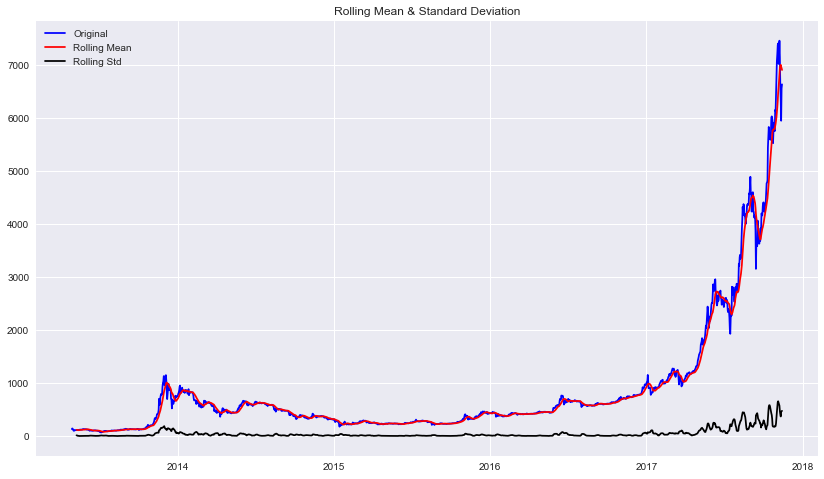

Results of Dickey-Fuller Test:
Test Statistic                    2.895758
p-value                           1.000000
#Lags Used                       24.000000
Number of Observations Used    1637.000000
Critical Value (1%)              -3.434351
Critical Value (5%)              -2.863307
Critical Value (10%)             -2.567711
dtype: float64


In [45]:
test_stationarity(BTC_Close)

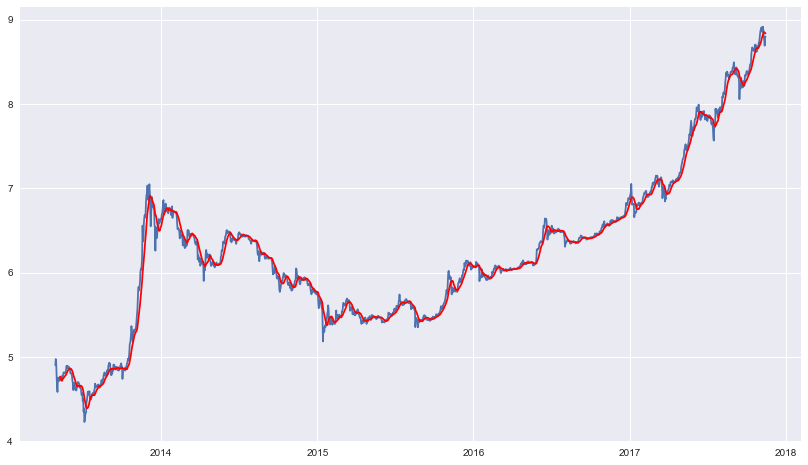

In [46]:
BTC_Close_log = np.log(BTC_Close)
moving_avg = BTC_Close_log.rolling(window=12,center=False).mean()

plt.plot(BTC_Close_log)
plt.plot(moving_avg, color='red')

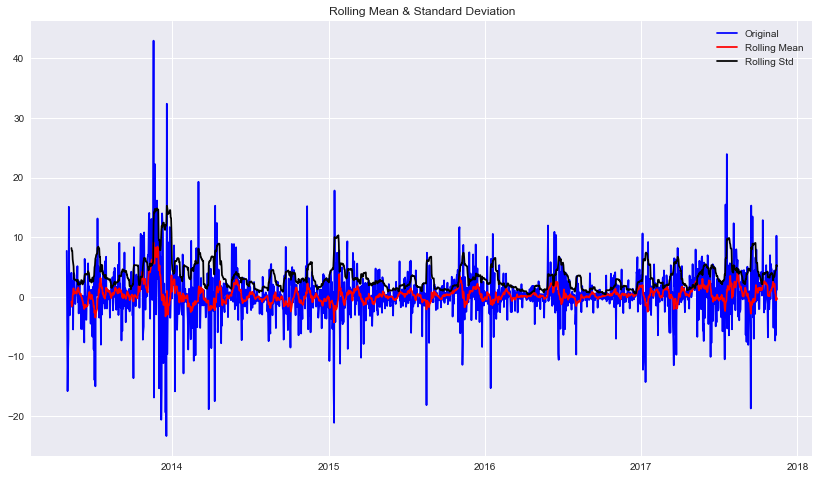

Results of Dickey-Fuller Test:
Test Statistic                    2.895758
p-value                           1.000000
#Lags Used                       24.000000
Number of Observations Used    1637.000000
Critical Value (1%)              -3.434351
Critical Value (5%)              -2.863307
Critical Value (10%)             -2.567711
dtype: float64


In [47]:
test_stationarity(BTC['BTC Daily Return'])

# Forecasting Time-Series data with Prophet

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

In Addetive Model:

Data = Seasonal effect + Trend + Cyclical + Residual


In [48]:
BTC['Weekday'] = BTC.index.dayofweek
BTC.index.name = 'Date'
BTC['date'] = BTC.index
BTC.reset_index(drop=True,inplace=True)
BTC.head()

Open    High     Low   Close Volume     Market Cap  BTC Daily Return  \
0  135.30  135.98  132.10  134.21      -  1,500,520,000               NaN   
1  134.44  147.49  134.00  144.54      -  1,491,160,000          7.696893   
2  144.00  146.93  134.05  139.00      -  1,597,780,000         -3.832849   
3  139.00  139.89  107.72  116.99      -  1,542,820,000        -15.834532   
4  116.38  125.60   92.28  105.21      -  1,292,190,000        -10.069237   

   Weekday       date  
0        6 2013-04-28  
1        0 2013-04-29  
2        1 2013-04-30  
3        2 2013-05-01  
4        3 2013-05-02

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


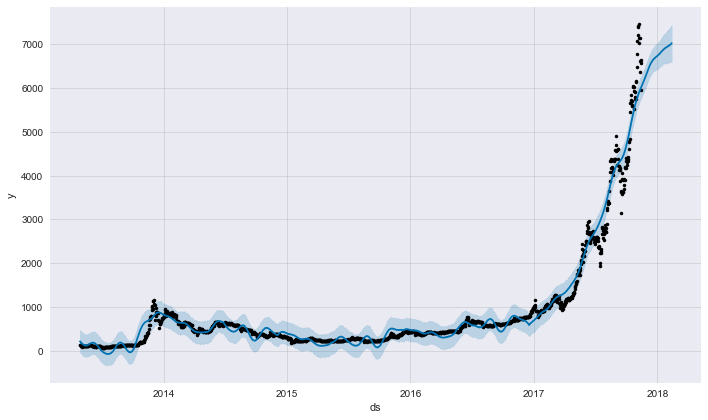

In [61]:
#!pip install pystan 
#!pip install fbprophet 

from fbprophet import Prophet
import seaborn as sns

sns.set(font_scale=1) 
df_date_index = BTC[['date','Close']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=90,freq='D')   #To make a DataFrame with 90 days datestamps to predict for
forecast = m.predict(future)
plt.figure(figsize=(10, 10))
fig = m.plot(forecast)

Here’s the prediction for the Bitcoin price three months into the future, plotted as a continuation of the existing input data.

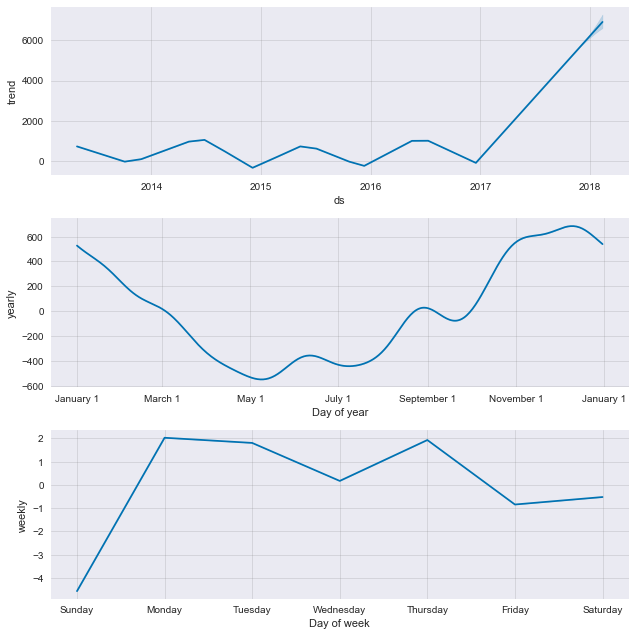

In [59]:
m.plot_components(forecast);


The increase in the price of Bitcoin in 2017 is not explanable using the last years seasonality.